This code is to fit a spectrum as the sum of two models, and really it's a sum of four models. 

The goal is to map out the space of possible delta-Teff and spot coverage fractions allowed.
I suspect I will have to run this with a prior on either delta-Teff or fS to get something meaningful because of degeneracies

To do:
<br /> -Test with models against models
<br /> -Read in observed spectra of K2-33
<br /> -Test LkCa 4 (if we have a spectrum)?
<br /> -Down-sample and smooth models to match data
<br /> -Test with fS = 0

In [14]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from emcee import EnsembleSampler
from multiprocessing import Pool
from corner import corner
from astropy.io import fits
from multiprocessing import Pool
from scipy import stats
from scipy import optimize
import numpy.random as random
import emcee
import corner
import random
from PyAstronomy import funcFit as fuf
from PyAstronomy import pyasl
from gaussfold import gaussfold as gf
from IPython.display import display, Math
from specutils.fitting import fit_continuum
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from astropy.modeling import models
import multiprocessing as mp
Pool = mp.get_context('fork').Pool
from dust_extinction.parameter_averages import F19
# define the model
ext = F19(Rv=3.1)

In [15]:
plt.rcParams['lines.linewidth']   =3
plt.rcParams['axes.linewidth']    = 2
plt.rcParams['xtick.major.width'] =2
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelweight']='semibold'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['axes.titleweight']='semibold'
plt.rcParams['axes.titlesize']=9

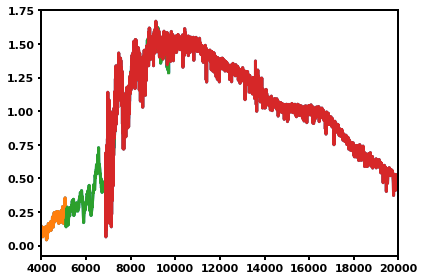

(8517,)


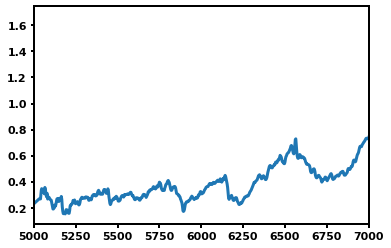

In [17]:
## read in data
obswav,obsspec,obserr,obstype = np.loadtxt('rawspec.txt',unpack=True,skiprows=1)

plt.plot(obswav,obsspec)
l1 = np.where(obstype == 1)
plt.plot(obswav[l1],obsspec[l1])
l2 = np.where(obstype == 2)
plt.plot(obswav[l2],obsspec[l2])
l3 = np.where(obstype == 3)
plt.plot(obswav[l3],obsspec[l3])
plt.xlim(4000,20000)
plt.tight_layout()
plt.show()

#l4 = np.where(((obstype ==1)| (obstype ==2)) & (obswav > 4000))
l4 = np.where((obswav > 4000) & (obswav<24000) & ((obswav > 8000)|(obstype<3)) & (obsspec > 0))
opticalspec = obsspec[l4]
opticalwav = obswav[l4]
opticalerr = obserr[l4]
l5 = np.where((obswav > 4000) & (obswav<23500) & (obsspec/obserr > 10))
## uncomment this when you want to run the fit again. 
#l5 = np.where((obswav > 4000) & (obswav<23500) & (obsspec/obserr > 15) & ((obswav > 6600)|(obswav<6300)))
obsspec_cut = np.array(obsspec[l5])
obswav_cut = np.array(obswav[l5])
obserr_cut = np.array(obserr[l5])
obstype_cut = np.array(obstype[l5])

print(np.shape(obswav_cut))
plt.plot(obswav_cut,obsspec_cut)
plt.tight_layout
plt.xlim(5000,7000)
plt.show()

In [18]:
#modelpath = '/Users/andrewmann/Dropbox/Radii/Models_CIFIST_Aug2013_filler.fits'
modelpath = '/Users/andrewmann/Dropbox/Radii/Models_CIFIST_Dupuy.fits'
hdul = fits.open(modelpath)
hdul.info()
hdr = hdul[1].header
data = hdul[1].data

#print(np.min(data['teff']),np.max(data['teff']))
#print(data['header'])

## trim the models to just solar metallicity 
teff = np.squeeze(data['teff'])
logg = np.squeeze(data['logg'])
afe = np.squeeze(data['a_fe'])
mh = np.squeeze(data['metal'])
spectra = np.squeeze(data['spectrum'])

loc = np.where((logg == 4.5) & (mh == 0) & (teff > 1000) & (afe == 0))
modelteff = teff[loc]
modelspectra = np.squeeze(spectra[:,loc])
lambda0 = 1000
nlambda = 149501
dlambda = 2
modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
ll = np.where((modelwave > 3000) & (modelwave < 53000))
#print(np.shape(ll))
modelspectra = np.squeeze(modelspectra[ll,:])
modelwave = modelwave[ll]
#print(np.shape(modelteff),np.shape(modelspectra),np.shape(modelwave))
#print(np.max(modelteff),np.min(modelteff))

## resample model spectra
newlambda = np.array(obswav_cut)
newmodel = np.zeros((np.size(newlambda),np.size(modelteff)))
for i in range(0,np.size(modelteff)):
    tmp = np.array(modelspectra[:,i])
    interpfunc = interpolate.interp1d(modelwave, tmp, kind='linear',fill_value="extrapolate")
    modelspec_new = interpfunc(newlambda)
    modelspec_new = gf(newlambda, modelspec_new, 5)
    newmodel[:,i] = modelspec_new

modelwave = newlambda
modelspectra = newmodel

Filename: /Users/andrewmann/Dropbox/Radii/Models_CIFIST_Dupuy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   1R x 7C   [3760A, 44252296E, 296E, 296E, 296E, 296E, 296E]   


In [19]:
def getspec(teffs,spectra, inteff): ##  for now other parameters are fixed
    loc = np.where(teffs == inteff)
    #print(inteff,np.shape(spectra),np.shape(teffs))
    above = np.min(np.where(teffs >= inteff))
    below = np.max(np.where(teffs < inteff))
    if np.size(below) < 1 or np.size(above) < 1:
        return(-np.inf)
    
    spec1 = np.squeeze(spectra[:,above])
    spec2 = np.squeeze(spectra[:,below])
    weight = (inteff-teffs[below])/(teffs[above]-teffs[below])
    spec = (1.-weight)*spec2 + weight*spec1
    #else:
    #    spec = np.squeeze(spectra[:,loc])
    return(spec)

## this will take two temperatures (spot and surf) 
##and a coverage fraction (fS) 
## and output the relevant spectrum
def doublespec(teffs,spectra, teff1,teff2,fS):
    spec1 = getspec(teffs,spectra,teff1)
    spec2 = getspec(teffs,spectra,teff2)
    spec = spec1*(1-fS) + spec2*fS
    return(spec)

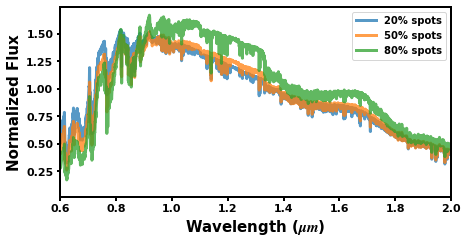

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 3.5)

## here let's make some example spectra to show off why this method works
#plt.plot(obswav_cut,obsspec_cut/np.median(obsspec_cut),label='data')
spec1 = doublespec(modelteff,modelspectra,3540,2900,0.2)
plt.plot(obswav_cut/1e4,spec1/np.median(spec1),label='20% spots',alpha=0.75)
spec2 = doublespec(modelteff,modelspectra,3540,2900,0.5)
plt.plot(obswav_cut/1e4,spec3/np.median(spec3),label='50% spots',alpha=0.75)
spec4 = doublespec(modelteff,modelspectra,3540,2900,0.8)
plt.plot(obswav_cut/1e4,spec4/np.median(spec4),label='80% spots',alpha=0.75)

plt.tight_layout
plt.xlim(0.6,2.0)
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
ax.set_ylabel(r'Normalized Flux')
ax.set_xlabel(r'Wavelength ($\mu m$)')
plt.show()


In [14]:
## the likelihood needs to fit a few parameters:
## 1) Tsurf
## 2) Tspot 
## 3) small lambda offsets
## 4) flux calibration errors?
## 5) fS
## 6) ??
#define functions for MCMC
def ln_prior(theta):
    Tsurf, Tspot, fS, a, b, c, AV, loff, f = theta
    if AV > 1.5 or AV < 0.3 or (loff < -3) or (loff > 3) or (Tspot < 2000) or (Tspot > 3900) or (Tsurf < 2000) or (Tsurf > 3900) or fS < 0.0 or fS > 1.0 or f < 0 or f > 0.1 or Tspot>(Tsurf-100) or a/b >2 or a/b < 0.5 or a/c < 0.5 or a/c > 2:
        return -np.inf
    return 0

## warning, wavelengths for model spectra and observational data must match
def ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr ):
    Tsurf, Tspot, fS, a, b, c, AV, loff, f = theta
    modelspec = doublespec(modelteff,modelspectra,Tsurf,Tspot,fS)
    newwav = wav + loff
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift = interpfunc(newwav)
    modelspec_smooth = modelspec_shift  
    reddened = modelspec_smooth*ext.extinguish(wav*u.AA, Av=AV)
        
    modelspec_norm = np.array(reddened)/np.mean(reddened)
    obsspec_norm = np.array(obsspec)/np.mean(obsspec)
    obsspec_err_norm = np.array(obserr)/np.mean(obsspec)
    obsspec_norm[np.where(obstype == 1)]*=a
    obsspec_norm[np.where(obstype == 2)]*=b
    obsspec_norm[np.where(obstype == 3)]*=c
    obsspec_err_norm[np.where(obstype == 1)]*=a
    obsspec_err_norm[np.where(obstype == 2)]*=b
    obsspec_err_norm[np.where(obstype == 3)]*=c    
    ## due to edge effects, we need to trim the first and last ~20 points
    diff = (modelspec_norm - obsspec_norm)
    s_squared = np.square(obsspec_err_norm) + np.square(f*obsspec_norm)
    p = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(diff) / (2. * s_squared)) 
    ## what if we just removed the 20 worst points instead?
    tmp = np.sort(p)
    #print(tmp)
    #print(tmp[int(np.round(np.size(tmp)*0.01)):np.size(tmp)])
    output = np.sum(np.log(tmp[int(np.round(np.size(tmp)*0.01)):np.size(tmp)]))
    #output = np.sum(np.log(p[20:np.size(modelspec_norm)-20]))
    return output

def ln_posterior(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr ):
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_like = ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr )
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like

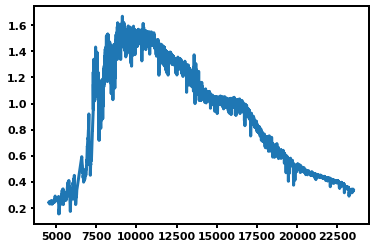

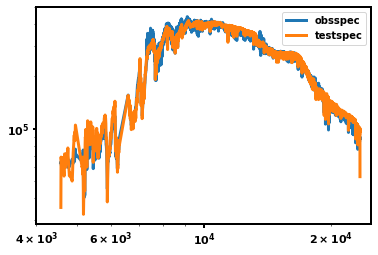

In [15]:
obsspec_cut = np.array(obsspec[l5])
obswav_cut = np.array(obswav[l5])
obserr_cut = np.array(obserr[l5])
obstype_cut = np.array(obstype[l5])
plt.plot(modelwave,obsspec_cut)
plt.show()
bluenorm, rednorm, irnorm = [294802.917,299787.751, 296800]
testspec = doublespec(modelteff,modelspectra,3540,2900,0.55)
red = ext.extinguish(modelwave*u.AA, Av=0.5)
testspec *= red
obsspec_plot = obsspec_cut/(np.median(obsspec_cut)/np.median(testspec))

plt.plot(modelwave,obsspec_plot,label='obsspec')
plt.plot(modelwave,testspec,label='testspec')
plt.xscale('log')
plt.yscale('log')
plt.xlim(4000,25000)
plt.legend()
plt.show()

In [16]:
nwalkers, ndim = 30, 9
nthreads = 12
ospec = np.array(list(obsspec_cut))
otype = np.array(list(obstype_cut))
oerr = np.array(list(obserr_cut))
mspec = np.array(list(modelspectra))
mteff = np.array(list(modelteff))
mwav = np.array(list(modelwave))

print('if this is inf, we have a problem:')
initial_guesses = [3500, 2500, 0.2, 1,1,1, 0.56, 1, 0.05]
print(ln_posterior(initial_guesses,mteff,mspec,mwav,ospec,otype,oerr))

pos0 = []
print('initializing walkers: (if you see a lot if inf, break this)')
while len(pos0) < nwalkers:
    trial = initial_guesses + 0.1 * np.random.randn(ndim)
    lp = ln_posterior(trial,mteff,mspec,mwav,ospec,otype,oerr)
    print(lp)
    if np.isfinite(lp):
        pos0.append(trial)

if this is inf, we have a problem:
[2.30085464e-34 4.80999234e-33 1.01528400e-31 ... 2.77761405e+01
 2.77927026e+01 3.33052865e+01]
[2.46375801e-11 4.32464342e-11 4.43142168e-11 ... 2.77761405e+01
 2.77927026e+01 3.33052865e+01]
9727.132975847593
initializing walkers: (if you see a lot if inf, break this)
-inf
-inf
-inf
[6.06482245e-09 1.95919143e-08 1.97799347e-08 ... 2.66392225e+01
 2.76254103e+01 2.86736605e+01]
[3.80828801e-03 3.99840375e-03 4.15350936e-03 ... 2.66392225e+01
 2.76254103e+01 2.86736605e+01]
1539.2064893245415
-inf
[1.38625758e-16 4.06265911e-16 2.15272961e-15 ... 1.44426802e+01
 1.45106052e+01 1.82069483e+01]
[1.26590001e-05 1.36718218e-05 1.50506230e-05 ... 1.44426802e+01
 1.45106052e+01 1.82069483e+01]
8350.281926834521
-inf
-inf
[1.51566338e-109 1.69953732e-084 4.87277424e-081 ... 4.96045715e+001
 5.00125207e+001 6.07500944e+001]
[4.96099219e-36 5.88191958e-36 7.71643623e-36 ... 4.96045715e+01
 5.00125207e+01 6.07500944e+01]
-8120.081552630807
-inf
-inf
-inf
-inf

In [28]:
nsteps = 10000
burn = 2000
thin = 5

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(mteff,mspec,mwav,ospec,otype,oerr), threads=nthreads)
sampler.run_mcmc(pos0, nsteps,progress=True)

print('done')

100%|██████████| 10000/10000 [09:09<00:00, 18.19it/s]


done


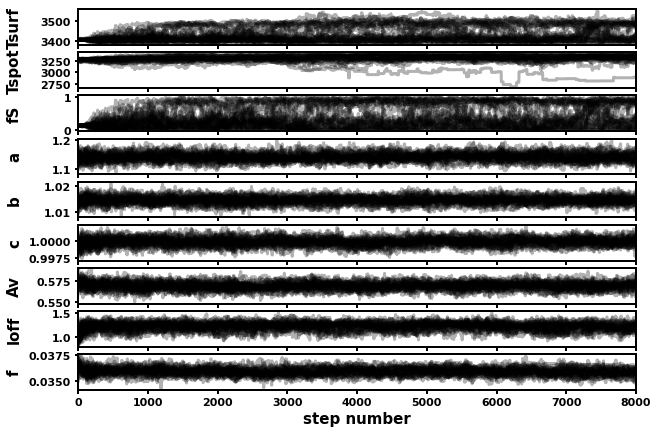

In [29]:
labels = ['Tsurf','Tspot','fS','a','b','c','Av','loff','f']
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burn)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
#plt.show()
plt.savefig('Walkers_specfit.pdf')

(48000, 9)


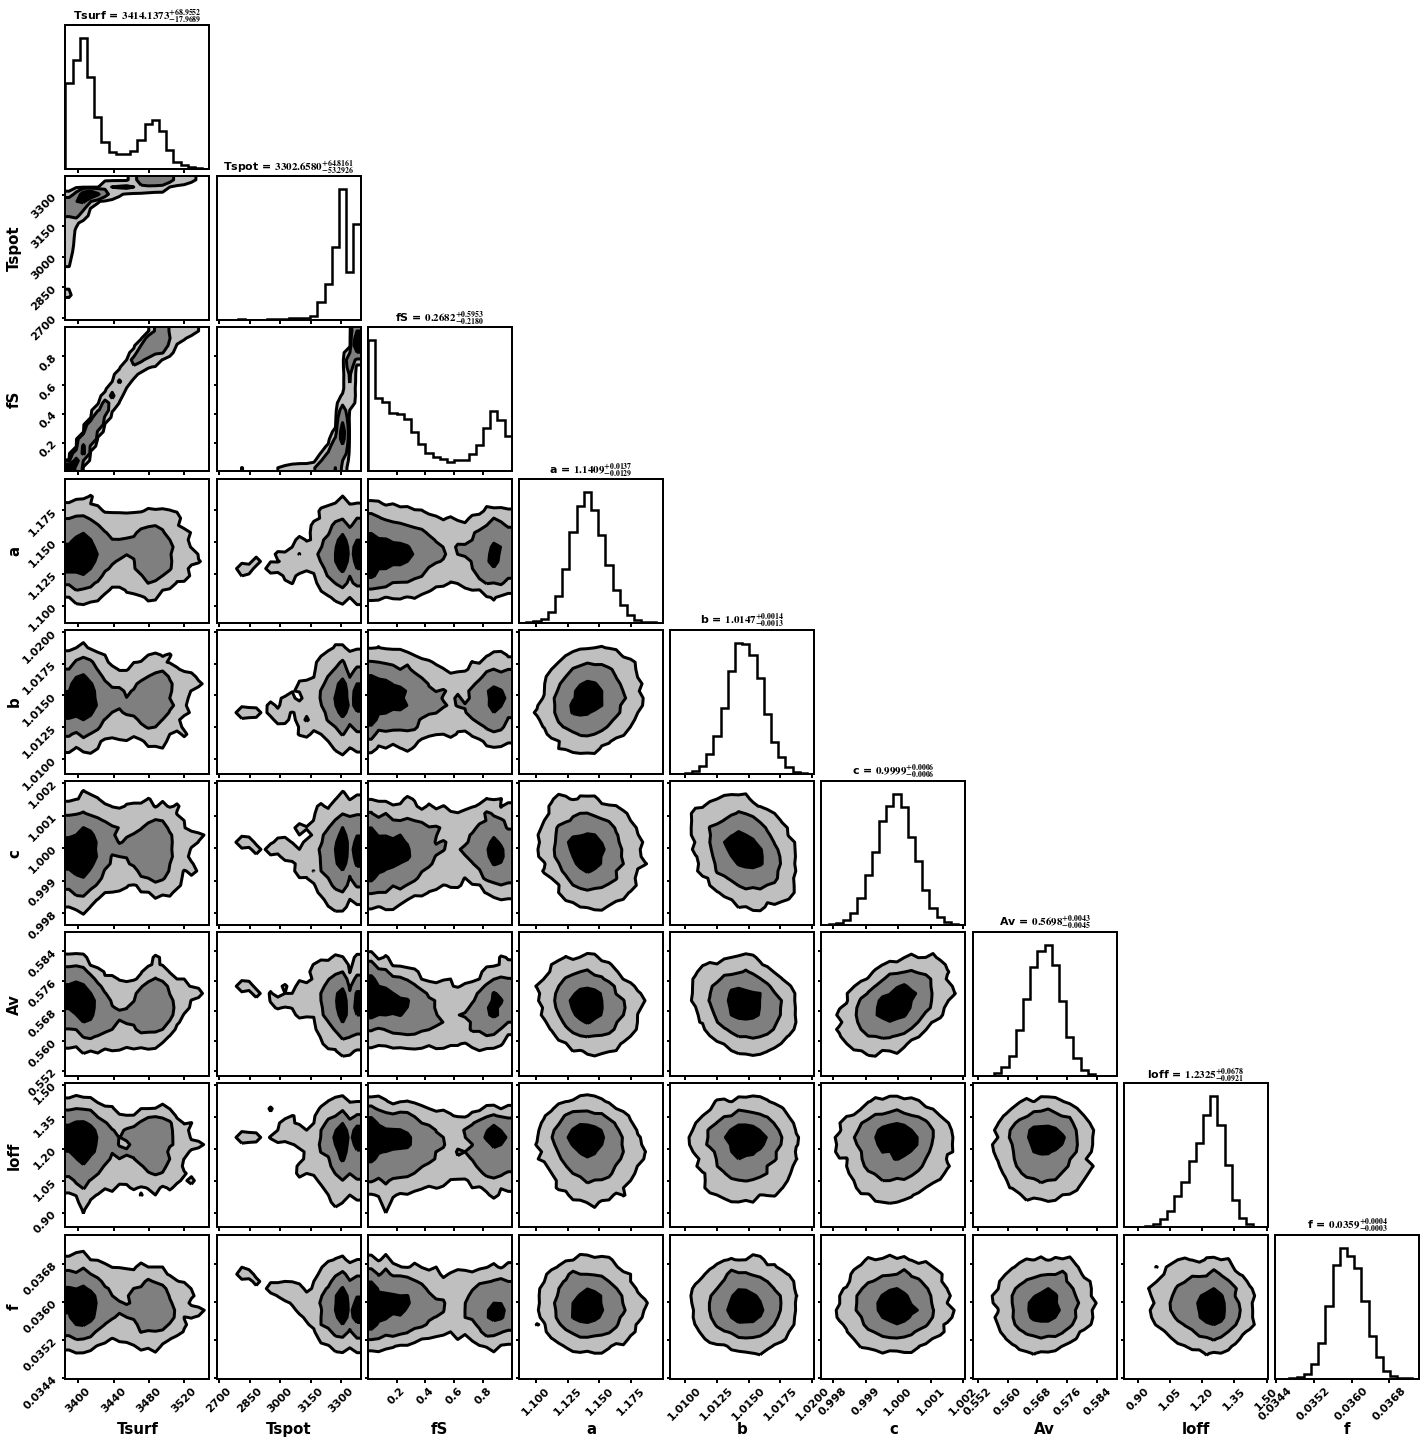

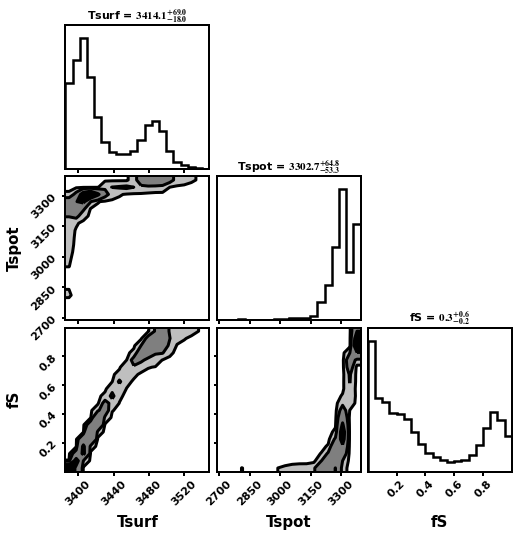

In [30]:
flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
print(flat_samples.shape)
fig = corner.corner( 
    flat_samples, labels=labels, show_titles=True,
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.4f',
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);

#plt.show()
plt.savefig('Corner_spec.pdf')


flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
trimmed_flat = flat_samples[:,0:3]
trimmed_labels = labels[0:3]
fig = corner.corner( 
    trimmed_flat, labels=trimmed_labels, show_titles=True,
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.1f',
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);

#plt.show()
plt.savefig('Corner_spec_trim.pdf')

In [12]:
## report best-fit parameters
best = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    #if i == 0:
    #    mcmc = np.percentile(np.exp(flat_samples[:, i]), [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    best.append(mcmc[1])

print(best)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[3380.6186978681867, 2000.1245294817522, 0.4395220727929815, 230550.61240748537, 194681.949589825, 197770.31624352233, 0.46426327086795804, 1.00578679522998, 0.06452501120512517]


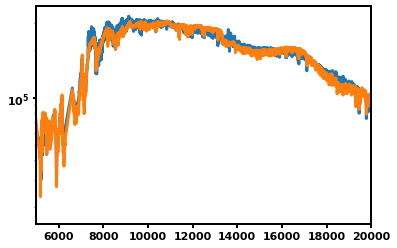

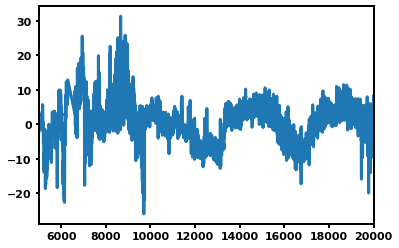

In [13]:
mteff = modelteff
modelspectra = mspec
wav = np.array(mwav)
obsspec = np.array(ospec)
obstype = np.array(otype)
obserr = np.array(oerr)
Tsurf, Tspot, fS, a, b, c, AV, loff, f = best
modelspec = doublespec(modelteff,modelspectra,Tsurf,Tspot,fS)
newwav = wav + loff
interpfunc = interpolate.interp1d(newwav, modelspec, kind='linear',fill_value="extrapolate")
modelspec_shift = interpfunc(wav)
modelspec_smooth = modelspec_shift  
reddened = modelspec_smooth*ext.extinguish(wav*u.AA, Av=AV)
    
#l = np.where(modelwave < 5200)
#reddened[l]/=a
modelspec_norm = np.array(reddened)
obsspec_norm = np.array(obsspec)
obsspec_err_norm = np.array(obserr)
obsspec_norm[np.where(obstype == 1)]*=a
obsspec_norm[np.where(obstype == 2)]*=b
obsspec_norm[np.where(obstype == 3)]*=c
obsspec_err_norm[np.where(obstype == 1)]*=a
obsspec_err_norm[np.where(obstype == 2)]*=b
obsspec_err_norm[np.where(obstype == 3)]*=c  

plt.plot(wav,obsspec_norm)
plt.plot(wav,reddened)
plt.yscale('log')
plt.xlim(5000,20000)
plt.show()

plt.plot(wav,(obsspec_norm-reddened)/obsspec_err_norm)
plt.xlim(5000,20000)#6050-6175
plt.show()

Below is us fiddling with the IGRINS data